In [55]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np
import copy
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/tmp/ipykernel_601354/981655211.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_p0, label='p0')
/tmp/ipykernel_601354/981655211.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_p1, label='p1')
/tmp/ipykernel_601354/981655211.py:13: UserWarning: 

`distplot` is a deprecated

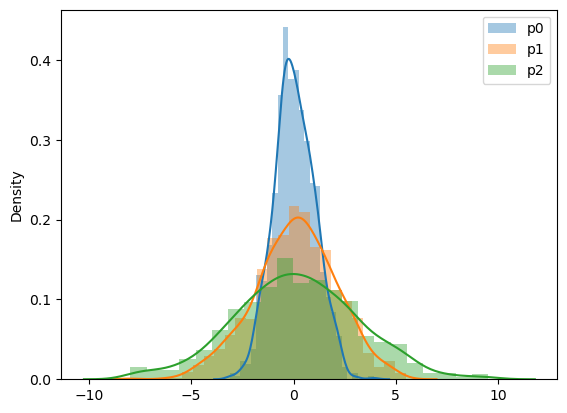

In [3]:
p0=D.Normal(0,1)
p1=D.Normal(0,2)
p2=D.Normal(0,3)

sample_p0=p0.sample((1000,))
sample_p1=p1.sample((1000,))
sample_p2=p2.sample((1000,))
sample_p0=sample_p0.numpy()
sample_p1=sample_p1.numpy()

sns.distplot(sample_p0, label='p0')
sns.distplot(sample_p1, label='p1')
sns.distplot(sample_p2, label='p2')
plt.legend()
plt.show()

In [4]:
#define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(1, 100)
        self.fc2=nn.Linear(100, 100)
        self.fc3=nn.Linear(100, 1)
        self.partition=nn.Parameter(torch.tensor([1.], requires_grad=True))
    
    def forward(self, x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return - x - torch.log(self.partition)
    
    def log_prob(self, x):
        return self.forward(x)

In [5]:
#nce value function

def value(energy, noise, x, gen,reweight=False,second_noise=None):
    logp_x = energy(x)  # logp(x)
    try:
        logq_x = noise.log_prob(x).cuda()  # logq(x)
    except:
        logq_x = noise.log_prob(x.clone().detach().cpu()).cuda()
    logp_gen = energy(gen)  # logp(x̃)
    try:
        logq_gen = noise.log_prob(gen).cuda()  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    value_data = logp_x - torch.logsumexp(torch.cat([logp_x, logq_x], dim=1), dim=1, keepdim=True)  # log[p(x)/(p(x) + q(x))]
    value_gen = logq_gen - torch.logsumexp(torch.cat([logp_gen, logq_gen], dim=1), dim=1, keepdim=True)  # log[q(x̃)/(p(x̃) + q(x̃))]
    if reweight:
        try:
            logq_gen2 = second_noise.log_prob(gen).cuda()  # logq(x̃)
        except:
            logq_gen2 = second_noise.log_prob(gen.clone().detach().cpu()).cuda()
        value_gen = torch.exp(logq_gen - logq_gen2) * value_gen 

    v = value_data.mean() + value_gen.mean()

    r_x = torch.sigmoid(logp_x - logq_x)
    r_gen = torch.sigmoid(logq_gen - logp_gen)

    acc = ((r_x > 1/2).sum() + (r_gen > 1/2).sum()).cpu().numpy() / (len(x) + len(gen))

    return -v,  acc

In [50]:
def langevin_mala(model,data,num_steps=1000,step_size=0.1):
    for i in range(num_steps):
        data.requires_grad_(True)
        data.retain_grad()
        model.zero_grad()
        logp_x=model.log_prob(data)
        logp_x.sum().backward()
        with torch.no_grad():
            data_mean=data+step_size*data.grad
            data_new=data_mean + np.sqrt(2*step_size)*torch.randn_like(data)
        model.zero_grad()
        data_new.requires_grad_(True)
        data_new.retain_grad()
        logp_x_new=model.log_prob(data_new)
        logp_x_new.sum().backward()
        with torch.no_grad():
            data_new_mean=data_new+step_size*data_new.grad
            probability_ratio=torch.exp(logp_x_new-logp_x)
            transition_ratio=torch.exp(-torch.norm(data-data_new_mean,dim=1)**2/(4*step_size)+torch.norm(data_new-data_mean,dim=1)**2/(4*step_size)).unsqueeze(1)
            acceptance_ratio=torch.min(torch.ones_like(probability_ratio),probability_ratio*transition_ratio)
            u=torch.rand_like(acceptance_ratio)
            data=data_new*(u<acceptance_ratio).float()+data*(u>=acceptance_ratio).float()
    return data



In [56]:
#nce training 
def train(p0,p1,p2=None,model_p0=None,training_iterations=10000, batch_size=10000,mala=False,model=None):
    if model is None:
        model=Net().cuda()
    if mala:
        base_model=copy.deepcopy(model)
        mala_samples=langevin_mala(base_model, p1.sample((10000,1)).cuda(),num_steps=1000,step_size=0.1)
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
    training_iterations=training_iterations
    batch_size=batch_size
    for i in range(training_iterations):
        optimizer.zero_grad()
        z=p1.sample((batch_size, 1)).cuda()
        loss, acc=value(model, p0, z, p0.sample((batch_size,1 )).cuda())
        if mala:
            z2=p1.sample((batch_size, 1)).cuda()
            loss2, acc2=value(model, base_model, z2, mala_samples)
            loss=(loss+loss2)/2
            acc=(acc+acc2)/2
        if p2 is not None:
            z2=p1.sample((batch_size, 1)).cuda()
            loss2, acc2=value(model, p0, z2, p2.sample((batch_size, 1)).cuda(),reweight=True,second_noise=p2)
            loss=loss+loss2
            acc=(acc+acc2)/2
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Iteration: %s, Loss: %s, Accuracy: %s' % (i, loss.item(), acc))
            if mala:
                base_model=copy.deepcopy(model)
                mala_samples=langevin_mala(base_model, p1.sample((10000,1)).cuda(),num_steps=1000,step_size=0.1)
    return model


In [75]:
model=train(p0, p1,training_iterations=10000)
print(model.partition.item())

Iteration: 0, Loss: 1.615786075592041, Accuracy: 0.5
Iteration: 100, Loss: 1.2499957084655762, Accuracy: 0.6138
Iteration: 200, Loss: 1.2120811939239502, Accuracy: 0.6597
Iteration: 300, Loss: 1.2045139074325562, Accuracy: 0.65775
Iteration: 400, Loss: 1.1962257623672485, Accuracy: 0.66185
Iteration: 500, Loss: 1.2041611671447754, Accuracy: 0.6549
Iteration: 600, Loss: 1.1947388648986816, Accuracy: 0.6659
Iteration: 700, Loss: 1.2016626596450806, Accuracy: 0.66215
Iteration: 800, Loss: 1.2069671154022217, Accuracy: 0.659
Iteration: 900, Loss: 1.210054636001587, Accuracy: 0.65445
Iteration: 1000, Loss: 1.208937406539917, Accuracy: 0.65745
Iteration: 1100, Loss: 1.1972795724868774, Accuracy: 0.66485
Iteration: 1200, Loss: 1.1993569135665894, Accuracy: 0.65965
Iteration: 1300, Loss: 1.2087613344192505, Accuracy: 0.6601
Iteration: 1400, Loss: 1.203717589378357, Accuracy: 0.65945
Iteration: 1500, Loss: 1.1952346563339233, Accuracy: 0.6641
Iteration: 1600, Loss: 1.1968326568603516, Accuracy:

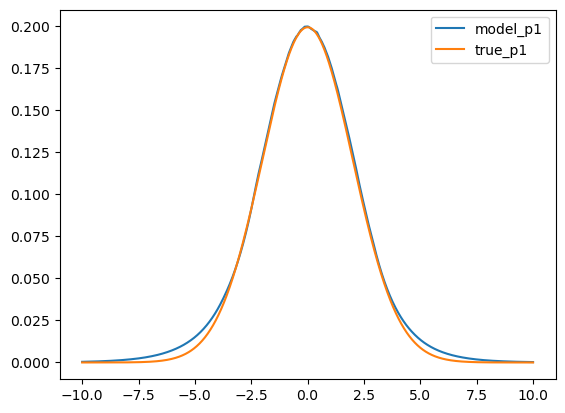

In [76]:
#plot model energy across x axis
x=np.linspace(-10, 10, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p1.log_prob(x).detach().cpu().squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()
plt.show()

## Try MALA chains with learn model


In [77]:
mala_data=langevin_mala(model,p1.sample((10000,1)).cuda(),num_steps=1000,step_size=0.1)

/tmp/ipykernel_601354/3460352009.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mala_data.detach().cpu().numpy(), label='mala')
/tmp/ipykernel_601354/3460352009.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(p1.sample((10000,)).numpy(), label='p1')


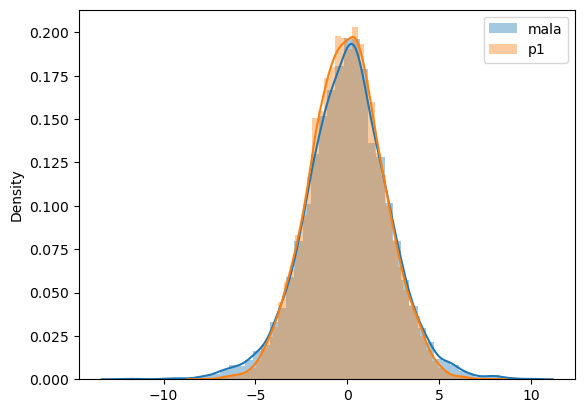

In [78]:
sns.distplot(mala_data.detach().cpu().numpy(), label='mala')
sns.distplot(p1.sample((10000,)).numpy(), label='p1')
plt.legend()

# refine with data generated from mala chains

In [79]:
model=train(p0, p1, training_iterations=20000,mala=True,model=model)

Iteration: 0, Loss: 1.2947783470153809, Accuracy: 0.32935
Iteration: 100, Loss: 1.2898927927017212, Accuracy: 0.585375
Iteration: 200, Loss: 1.295374870300293, Accuracy: 0.58375
Iteration: 300, Loss: 1.2927430868148804, Accuracy: 0.586625
Iteration: 400, Loss: 1.2915117740631104, Accuracy: 0.58255
Iteration: 500, Loss: 1.2921613454818726, Accuracy: 0.5858
Iteration: 600, Loss: 1.2953555583953857, Accuracy: 0.5864
Iteration: 700, Loss: 1.290329933166504, Accuracy: 0.582475
Iteration: 800, Loss: 1.2959325313568115, Accuracy: 0.5834
Iteration: 900, Loss: 1.291882038116455, Accuracy: 0.583975
Iteration: 1000, Loss: 1.2978696823120117, Accuracy: 0.5807
Iteration: 1100, Loss: 1.295804500579834, Accuracy: 0.5822
Iteration: 1200, Loss: 1.292754888534546, Accuracy: 0.5865750000000001
Iteration: 1300, Loss: 1.2945905923843384, Accuracy: 0.5822499999999999
Iteration: 1400, Loss: 1.2908176183700562, Accuracy: 0.5887
Iteration: 1500, Loss: 1.2947778701782227, Accuracy: 0.581825
Iteration: 1600, Los

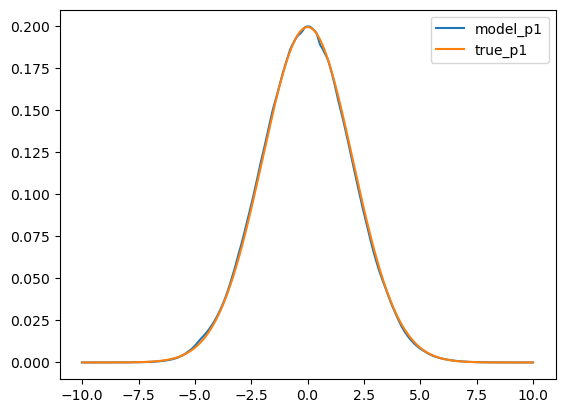

In [80]:
#plot model energy across x axis
x=np.linspace(-10, 10, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p1.log_prob(x).detach().cpu().squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()
plt.show()

# using two base distributions

In [38]:
model=train(p0, p1, p1,model_p0 =model,training_iterations=50000, batch_size=10000)
print(model.partition.item())


Iteration: 0, Loss: 3.6007943153381348, Accuracy: 0.5
Iteration: 100, Loss: 2.5937952995300293, Accuracy: 0.5
Iteration: 200, Loss: 2.4294304847717285, Accuracy: 0.578625
Iteration: 300, Loss: 2.4079079627990723, Accuracy: 0.581
Iteration: 400, Loss: 2.4019203186035156, Accuracy: 0.582


KeyboardInterrupt: 

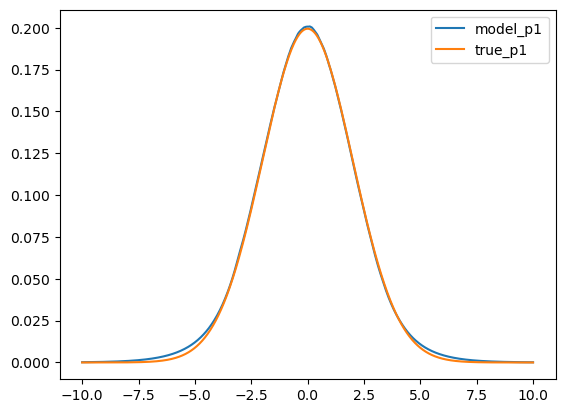

In [23]:
#plot model energy across x axis
x=np.linspace(-10, 10, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p1.log_prob(x).detach().cpu().squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()
plt.show()

# sampling from two base distributions but using only 1


In [24]:
model=train(p0, p1, p1)
print(model.partition.item())

Iteration: 0, Loss: 3.608120918273926, Accuracy: 0.5
Iteration: 100, Loss: 2.6171183586120605, Accuracy: 0.5
Iteration: 200, Loss: 2.427334785461426, Accuracy: 0.581025
Iteration: 300, Loss: 2.414479970932007, Accuracy: 0.5784
Iteration: 400, Loss: 2.408876895904541, Accuracy: 0.581125
Iteration: 500, Loss: 2.398684024810791, Accuracy: 0.5813250000000001
Iteration: 600, Loss: 2.403277635574341, Accuracy: 0.5782
Iteration: 700, Loss: 2.390130043029785, Accuracy: 0.5819749999999999
Iteration: 800, Loss: 2.4069736003875732, Accuracy: 0.5780749999999999
Iteration: 900, Loss: 2.406614303588867, Accuracy: 0.57655
Iteration: 1000, Loss: 2.387021064758301, Accuracy: 0.5811
Iteration: 1100, Loss: 2.403074264526367, Accuracy: 0.581725
Iteration: 1200, Loss: 2.3969156742095947, Accuracy: 0.5825
Iteration: 1300, Loss: 2.395709991455078, Accuracy: 0.58505
Iteration: 1400, Loss: 2.396527051925659, Accuracy: 0.582425
Iteration: 1500, Loss: 2.4096384048461914, Accuracy: 0.577625
Iteration: 1600, Loss:

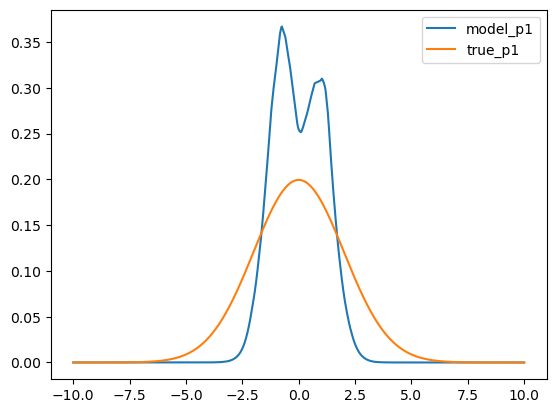

In [8]:
#plot model energy across x axis
x=np.linspace(-10, 10, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p1.log_prob(x).detach().cpu().squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()
plt.show()

#Unimodal to bimodal

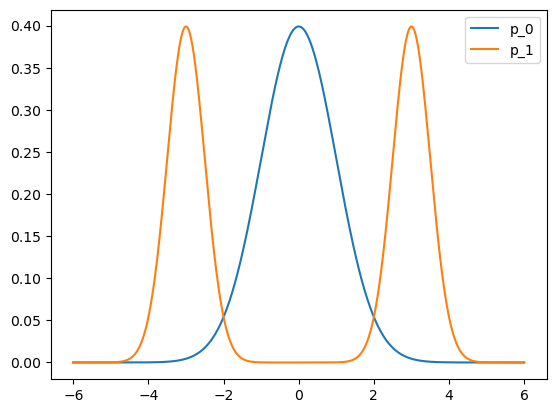

In [6]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,1)
    if vars is None:
        vars = torch.rand(n_modes,1)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_means = torch.zeros(1)
p_0_vars = torch.ones(1)
p_0 = D.Normal(p_0_means, p_0_vars)


p_1_means = torch.tensor([[3], [ -3]]).float()
p_1_vars = torch.ones(2,1)*0.5
p_1 = build_gmm(2, p_1_means, p_1_vars)

x = torch.linspace(-6, 6, 1000).unsqueeze(1)
plt.plot(x, torch.exp(p_0.log_prob(x)), label='p_0')
plt.plot(x, torch.exp(p_1.log_prob(x)), label='p_1')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()

In [54]:
model=train(p_0, p_1)
print(model.partition.item())


Iteration: 0, Loss: 1.7967603206634521, Accuracy: 0.5


Iteration: 100, Loss: 1.7223995923995972, Accuracy: 0.5
Iteration: 200, Loss: 1.6613216400146484, Accuracy: 0.5
Iteration: 300, Loss: 1.5832459926605225, Accuracy: 0.5
Iteration: 400, Loss: 1.5121911764144897, Accuracy: 0.5
Iteration: 500, Loss: 1.4452838897705078, Accuracy: 0.5
Iteration: 600, Loss: 1.3766900300979614, Accuracy: 0.5
Iteration: 700, Loss: 1.3152185678482056, Accuracy: 0.5
Iteration: 800, Loss: 1.2493976354599, Accuracy: 0.5
Iteration: 900, Loss: 1.176522970199585, Accuracy: 0.5
Iteration: 1000, Loss: 1.118747591972351, Accuracy: 0.5
Iteration: 1100, Loss: 1.0660632848739624, Accuracy: 0.5
Iteration: 1200, Loss: 1.0246217250823975, Accuracy: 0.60485
Iteration: 1300, Loss: 0.9684858918190002, Accuracy: 0.66905
Iteration: 1400, Loss: 0.9336013793945312, Accuracy: 0.7089
Iteration: 1500, Loss: 0.8977780342102051, Accuracy: 0.7494
Iteration: 1600, Loss: 0.8591397404670715, Accuracy: 0.79275
Iteration: 1700, Loss: 0.8207611441612244, Accuracy: 0.8307
Iteration: 1800, Loss: 0

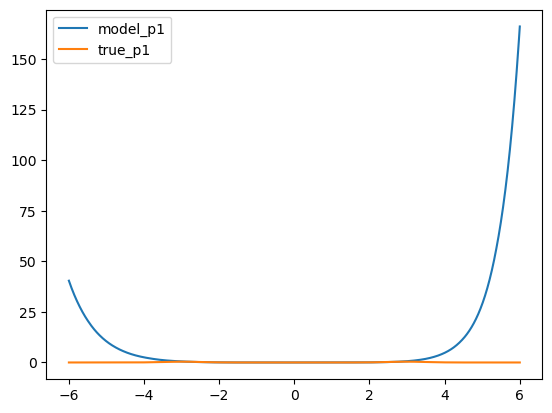

In [55]:
x=np.linspace(-6, 6, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()

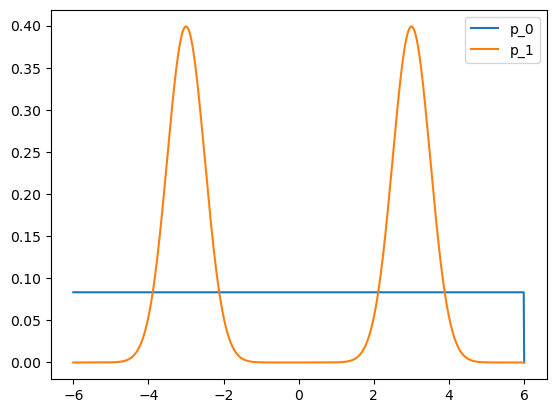

In [8]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,1)
    if vars is None:
        vars = torch.rand(n_modes,1)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_low = -6
p_0_high = 6
p_0 = D.Uniform(p_0_low, p_0_high)


p_1_means = torch.tensor([[3], [ -3]]).float()
p_1_vars = torch.ones(2,1)*0.5
p_1 = build_gmm(2, p_1_means, p_1_vars)

x = torch.linspace(-6, 6, 1000).unsqueeze(1)
plt.plot(x, torch.exp(p_0.log_prob(x)), label='p_0')
plt.plot(x, torch.exp(p_1.log_prob(x)), label='p_1')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()

In [9]:
model=train(p_0, p_1)
print(model.partition.item())

Iteration: 0, Loss: 2.627863883972168, Accuracy: 0.5
Iteration: 100, Loss: 2.3554766178131104, Accuracy: 0.5
Iteration: 200, Loss: 2.1139421463012695, Accuracy: 0.5
Iteration: 300, Loss: 1.898734450340271, Accuracy: 0.5
Iteration: 400, Loss: 1.7429999113082886, Accuracy: 0.5
Iteration: 500, Loss: 1.6270837783813477, Accuracy: 0.5662
Iteration: 600, Loss: 1.5620301961898804, Accuracy: 0.62115
Iteration: 700, Loss: 1.5173816680908203, Accuracy: 0.6558
Iteration: 800, Loss: 1.5006781816482544, Accuracy: 0.6557
Iteration: 900, Loss: 1.4884743690490723, Accuracy: 0.6509
Iteration: 1000, Loss: 1.477891445159912, Accuracy: 0.6419
Iteration: 1100, Loss: 1.4701097011566162, Accuracy: 0.6343
Iteration: 1200, Loss: 1.4634032249450684, Accuracy: 0.6294
Iteration: 1300, Loss: 1.4619783163070679, Accuracy: 0.6237
Iteration: 1400, Loss: 1.4581358432769775, Accuracy: 0.61875
Iteration: 1500, Loss: 1.4478392601013184, Accuracy: 0.6234
Iteration: 1600, Loss: 1.4317017793655396, Accuracy: 0.62935
Iterati

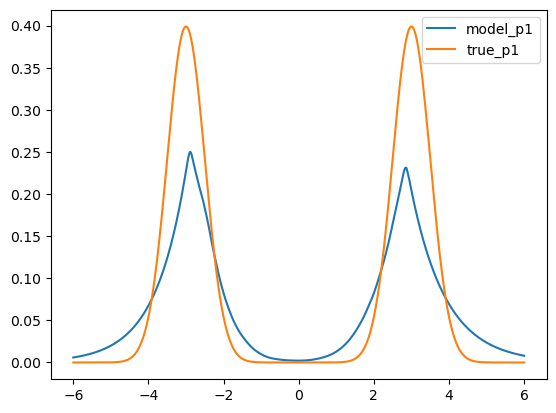

In [10]:
x=np.linspace(-6, 6, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()